# Task:
The goal of this task is to evaluate your data preparation, analysis and modeling skills. You receive on-time airline performance data and the question we would like you to answer is:
- What departure delay is expected for any scheduled flight in the test set?
- What is the performance of the model's prediction on the test set?

## Things to note:
- The data consists of 14 months, where 12 months (07.2018 - 06.2019) are for training/validation and 2 months (07.2019 - 08.2019) for testing purposes.
- `DepDelay` (in minutes) is your target variable.
- From an operational perspective, flight is classified as delayed, when it is late 15 minutes or more.
- Scheduled departure time of the flight is the last available moment for doing prediction.
- Feel free to use any publicly available information/dataset for feature engineering.
- Don’t forget about exploratory data analysis (at least 2 questions & answers).

## Tips:
- The goal is to test how you structure your thoughts and code, not whether or not you can achieve a specific performance metric.
- The assignment is meant to be highly open-ended but not needlessly laborious. Make judicious assumptions/decisions in your approach but document your rationale and what might be different in a less time-constrained scenario.
- If any directions are unclear, please make an assumption, note that assumption in your response, and continue on the basis of that assumption.
- There is no need for intense hyperparameter tuning (if training takes too long). 

We will evaluate your work as a whole, so a creative and thoughtful approach to the data and modeling is more important than getting a small improvement in your evaluation metric.  
Our preferred format is Jupyter notebook (with printed results & your notes), but if you use other tools, then any form including source code + explanation would be accepted.

### TODO:
- add note about no discussion after, be clear in notebook

### Import packages


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## My approach plan:
- New column as target - `Delay` [True or False]
- Create a model to predict `Delay`, as well as models for each type of delays (weather, nas, etc. delays) and so if any of them classifies as True, predict delay==True
- Very imbalanced data (assumed much more intimes than delays), so when train / test split make sure to use stratify, as well as stratify by date (different times of month should be covered).
- **Departure date** should be broken into: `weekday`, `date` (first half and second half of month rates of delays might differ), `month`
- Can be created additional feature like `red eye flight`, etc depending on **departure time**
- Can import weather information for dates to according departure and arrival airports, should help to predict some weather delays


## EDA plans:
- Most popular reason for delays
- Each airport: delays by -weekday; -month; -date; -type of delay
- Airlines by % of delays, flights by % of delays, Origin airport by % of delays
- Airports can be grouped by states/zones



In [49]:
dataset_dir = "../content/drive/MyDrive/flyr_dataset"

df = pd.read_csv(f'{dataset_dir}/07_2018.csv')
df.head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
0,2018-07-01,YV,5867,BOI,PHX,1135,1134.0,-1.0,1243,1230.0,...,128.0,116.0,99.0,735.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-07-01,YV,5867,PHX,BOI,745,740.0,-5.0,1049,1050.0,...,124.0,130.0,104.0,735.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-07-01,YV,5868,PHX,AMA,1845,1840.0,-5.0,2232,2214.0,...,107.0,94.0,79.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-07-01,YV,5869,AMA,PHX,914,859.0,-15.0,920,921.0,...,126.0,142.0,85.0,602.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-07-01,YV,5870,PHX,TUS,2005,2004.0,-1.0,2048,2050.0,...,43.0,46.0,28.0,110.0,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df.shape

(645299, 23)

In [51]:
df.columns

Index(['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME', 'ARR_TIME',
       'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 22'],
      dtype='object')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645299 entries, 0 to 645298
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   FL_DATE              645299 non-null  object 
 1   OP_UNIQUE_CARRIER    645299 non-null  object 
 2   OP_CARRIER_FL_NUM    645299 non-null  int64  
 3   ORIGIN               645299 non-null  object 
 4   DEST                 645299 non-null  object 
 5   CRS_DEP_TIME         645299 non-null  int64  
 6   DEP_TIME             634782 non-null  float64
 7   DEP_DELAY            634146 non-null  float64
 8   CRS_ARR_TIME         645299 non-null  int64  
 9   ARR_TIME             634018 non-null  float64
 10  ARR_DELAY            631789 non-null  float64
 11  CANCELLED            645299 non-null  float64
 12  CANCELLATION_CODE    11083 non-null   object 
 13  CRS_ELAPSED_TIME     645299 non-null  float64
 14  ACTUAL_ELAPSED_TIME  632164 non-null  float64
 15  AIR_TIME         

From information of flights in July 2018:
- Not every real departure time is available in dataframe (634,782 out of 645,299)
- Even less `dep_delay` times are available. Will need to calculate myself.
- 11,083 flights are cancelled
- 142,650 flights are delayed
- It will be interesting to check what is written in delay times incase flight is cancelled

In [53]:
df[df['CANCELLED']==1].head()

,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,...,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
123,2018-07-01,YV,5995,DFW,LBB,1850,1859.0,9.0,1958,NaN,...,68.0,NaN,NaN,282.0,NaN,NaN,NaN,NaN,NaN,NaN
274,2018-07-01,AA,2208,ORD,AUS,2005,NaN,NaN,2244,NaN,...,159.0,NaN,NaN,977.0,NaN,NaN,NaN,NaN,NaN,NaN
294,2018-07-01,AA,2231,BOS,ORD,1726,NaN,NaN,1935,NaN,...,189.0,NaN,NaN,867.0,NaN,NaN,NaN,NaN,NaN,NaN
313,2018-07-01,AA,2247,ORD,PDX,1740,NaN,NaN,2005,NaN,...,265.0,NaN,NaN,1739.0,NaN,NaN,NaN,NaN,NaN,NaN
380,2018-07-01,AA,1023,MIA,DTW,1950,NaN,NaN,2257,NaN,...,187.0,NaN,NaN,1145.0,NaN,NaN,NaN,NaN,NaN,NaN


From the row 123, `dep_delay` time is 9 minutes, however the flight is cancelled. So should drop flights that are cancelled first, and only then consider delayed flights.

In [54]:
df.describe()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 22
count,645299.000000,645299.000000,634782.000000,634146.000000,645299.000000,634018.000000,631789.000000,645299.000000,645299.000000,632164.000000,632164.000000,645299.000000,142650.000000,142650.000000,142650.000000,142650.000000,142650.000000,0.0
mean,2545.699391,1334.020648,1337.691734,13.628332,1478.234528,1445.539753,9.098327,0.017175,142.045856,137.720153,112.352042,819.179924,19.118058,4.376460,16.804059,0.082299,28.722257,NaN
std,1818.710195,498.048666,518.030479,48.945389,529.106865,559.598805,50.895688,0.129923,73.896393,74.132479,71.532977,612.213599,55.467971,29.600792,39.216891,2.699017,51.548889,NaN
min,1.000000,1.000000,1.000000,-47.000000,1.000000,1.000000,-88.000000,0.000000,1.000000,16.000000,8.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,1008.000000,912.000000,911.000000,-5.000000,1052.000000,1032.000000,-13.000000,0.000000,89.000000,83.000000,60.000000,370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2122.000000,1325.000000,1326.000000,-2.000000,1511.000000,1452.000000,-4.000000,0.000000,123.000000,119.000000,93.000000,646.000000,0.000000,0.000000,2.000000,0.000000,6.000000,NaN
75%,3936.000000,1742.000000,1754.000000,11.000000,1919.000000,1916.000000,11.000000,0.000000,171.000000,168.000000,141.000000,1050.000000,17.000000,0.000000,19.000000,0.000000,37.000000,NaN
max,7439.000000,2359.000000,2400.000000,2710.000000,2359.000000,2400.000000,2692.000000,1.000000,656.000000,736.000000,659.000000,4983.000000,1861.000000,2692.000000,1194.000000,636.000000,1253.000000,NaN


From statistical information of flights in July 2018:
- Average departure delay time is 13.6 minutes, and the median is -2 (two mintutes earlier than planned). While median arrival delay is -13 minutes, which means that planes fly less time than scheduled initially.
- 1.7% of flights in july were cancelled.
- median flight distance is 646 miles while median air time is 93 minutes.
- The cases that I thought are delayed (142,650 due to specific reasons) might not be delays at all. According to task, delay is if plane departed 15 mins later than planned. However in many cases

In [55]:
df.describe(include=['O'])

,FL_DATE,OP_UNIQUE_CARRIER,ORIGIN,DEST,CANCELLATION_CODE
count,645299,645299,645299,645299,11083
unique,31,17,349,349,3
top,2018-07-13,WN,ATL,ATL,C
freq,22022,120114,34745,34733,4204


Provided data is for 17 airlines and 349 airports. Southwest is the most flying airline and Atlanta is the airport with most incoming and outgoing flights.  
Also the last column `Unnamed: 22` looks useless, so I check which values it contains.

In [56]:
# Check last column, looks useless
df['Unnamed: 22'].unique()

array([nan])

## Loading the data

In [57]:
months = list(range(7,13)) + list(range(1,7))
files = []
for month in months:
    if month < 7:
      filename = f'{dataset_dir}/{month:02}_2019.csv'
    else:
      filename = f'{dataset_dir}/{month:02}_2018.csv'
    files.append(filename)

train_df = pd.concat((pd.read_csv(filename) for filename in files), ignore_index= True)

test_files = [f'{dataset_dir}/07_2019.csv', f'{dataset_dir}/08_2019.csv']

test_df = pd.concat((pd.read_csv(filename) for filename in test_files))

In [58]:
train_df.head(), train_df.shape

(      FL_DATE OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN DEST  CRS_DEP_TIME  \
 0  2018-07-01                YV               5867    BOI  PHX          1135   
 1  2018-07-01                YV               5867    PHX  BOI           745   
 2  2018-07-01                YV               5868    PHX  AMA          1845   
 3  2018-07-01                YV               5869    AMA  PHX           914   
 4  2018-07-01                YV               5870    PHX  TUS          2005   
 
    DEP_TIME  DEP_DELAY  CRS_ARR_TIME  ARR_TIME  ...  CRS_ELAPSED_TIME  \
 0    1134.0       -1.0          1243    1230.0  ...             128.0   
 1     740.0       -5.0          1049    1050.0  ...             124.0   
 2    1840.0       -5.0          2232    2214.0  ...             107.0   
 3     859.0      -15.0           920     921.0  ...             126.0   
 4    2004.0       -1.0          2048    2050.0  ...              43.0   
 
    ACTUAL_ELAPSED_TIME AIR_TIME  DISTANCE  CARRIER_DELAY  WEATHER

In [59]:
print(f"Delayed flights in training set: {(train_df['DEP_DELAY']>=15).sum()}")
print(f"Delayed flights in test set: {(test_df['DEP_DELAY']>=15).sum()}")

Delayed flights in training set: 1358361
Delayed flights in test set: 267491


In [60]:
train_df['Delay'] = train_df['DEP_DELAY'].apply(lambda x: 1 if x >= 15 else 0)
test_df['Delay'] = test_df['DEP_DELAY'].apply(lambda x: 1 if x >= 15 else 0)

print(f"Target labels in training set: {train_df['Delay'].sum()}")
print(f"Target labels in testing set: {test_df['Delay'].sum()}")

Target labels in training set: 1358361
Target labels in testing set: 267491


## EDA plans:
- Most popular reason for delays
Each airport: delays by -weekday; -month; -date; -type of delay
- Airlines by % of delays, flights by % of delays, - Origin airport by % of delays
- Airports can be grouped by states/zones

In [61]:
def populateDates(df):
  df['FL_DATE'] = df['FL_DATE'].astype('datetime64')
  df['Day'] = df['FL_DATE'].dt.day
  df['Month'] = df['FL_DATE'].dt.month
  df['Weekday'] = df['FL_DATE'].dt.weekday

populateDates(train_df)
populateDates(test_df)

In [62]:
g = sns.FacetGrid(train_df, col = 'Delay')
g.map(plt.hist, 'Month', alpha = 0.5, bins = 12, density = True)

Seems like my dataframe misses some monthes, so I check missing monthes files. From the chart above it is clear that there are more delays in June. 

In [63]:
# There are only July, August, October, January, April and June
train_df['Month'].unique()

array([ 7,  8, 10,  1,  4,  6])

In [64]:
df1= pd.read_csv('../content/drive/MyDrive/flyr_dataset/01_2019.csv')
df2= pd.read_csv('../content/drive/MyDrive/flyr_dataset/02_2019.csv')
df3= pd.read_csv('../content/drive/MyDrive/flyr_dataset/03_2019.csv')
print(df1['FL_DATE'].unique())
print(df2['FL_DATE'].unique())
print(df3['FL_DATE'].unique())
del df1
del df2
del df3

['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15'
 '2019-01-16' '2019-01-17' '2019-01-18' '2019-01-19' '2019-01-20'
 '2019-01-21' '2019-01-22' '2019-01-23' '2019-01-24' '2019-01-25'
 '2019-01-26' '2019-01-27' '2019-01-28' '2019-01-29' '2019-01-30'
 '2019-01-31']
['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-01-14' '2019-01-15'
 '2019-01-16' '2019-01-17' '2019-01-18' '2019-01-19' '2019-01-20'
 '2019-01-21' '2019-01-22' '2019-01-23' '2019-01-24' '2019-01-25'
 '2019-01-26' '2019-01-27' '2019-01-28' '2019-01-29' '2019-01-30'
 '2019-01-31']
['2019-01-01' '2019-01-02' '2019-01-03' '2019-01-04' '2019-01-05'
 '2019-01-06' '2019-01-07' '2019-01-08' '2019-01-09' '2019-01-10'
 '2019-01-11' '2019-01-12' '2019-01-13' '2019-

It seems like some datasets are just copies of others, and by loading them I am just duplicating data. Now I need to drop duplicate data.

In [65]:
print(f'Shape before dropping duplicates: {train_df.shape}')
train_df.drop_duplicates(inplace = True)
print(f'Shape after dropping duplicates: {train_df.shape}')

Shape before dropping duplicates: (7395640, 27)
Shape after dropping duplicates: (3738772, 27)


In [66]:
g = sns.FacetGrid(train_df, col = 'Delay')
g.map(plt.hist, 'Weekday', alpha = 0.5, bins = 7, density = True)

From histograms above I wanted to find an effect of the weekday on probablity of delay happening. It is clear that likelihood of delay happening on Monday and Friday is higher as well as on Saturday it is lower. (0 - Monday, 6 - Sunday).  


Next I wanna check rate of delayed flights by airlines.

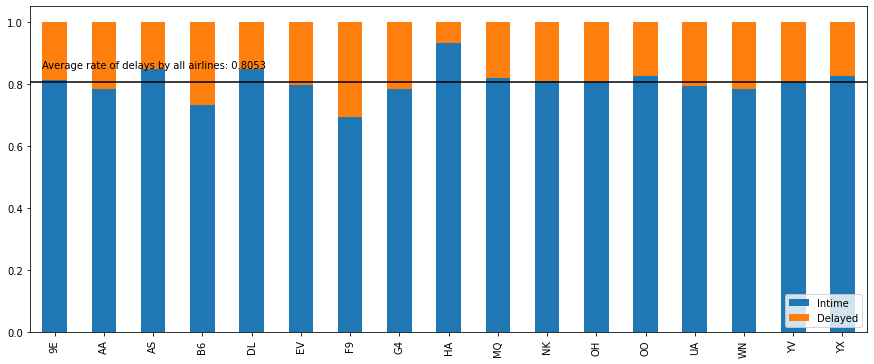

In [67]:
def aggregateAndPlot(parameter, textForPlot):
  airlines = train_df[parameter].unique()

  l = []
  for airline in airlines:
      l.append(train_df[train_df[parameter]== airline]['Delay'].value_counts(normalize = True))

  airlines_df = pd.DataFrame(l, index = airlines).round(4)
  del l
  
  airlines_df.sort_index(inplace = True)
  airlines_df.plot(kind = 'bar', stacked = True, figsize = [15,6])
  plt.legend(labels = ['Intime', 'Delayed'],loc = 4)
  y_dist = train_df['Delay'].value_counts()
  y_line = y_dist[0]/y_dist.sum()
  plt.axhline(y=y_line, color = 'k')
  plt.text(x = -0.25, y = 0.85, s = f'Average rate of delays by all {textForPlot}: {y_line.round(4)}')
  plt.show()

aggregateAndPlot('OP_UNIQUE_CARRIER', 'airlines')

Chart above indicates that delay rate varies from airline to airline and it should be taken into account.

Will try same to airports (origin)...

In [68]:
aggregateAndPlot('ORIGIN', 'airports')

Even if it is crowded and difficult to see, it is clear that rate of delays heavily depends on airport of origin.

Another thing to check if delay depends on time of the day flight happens.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


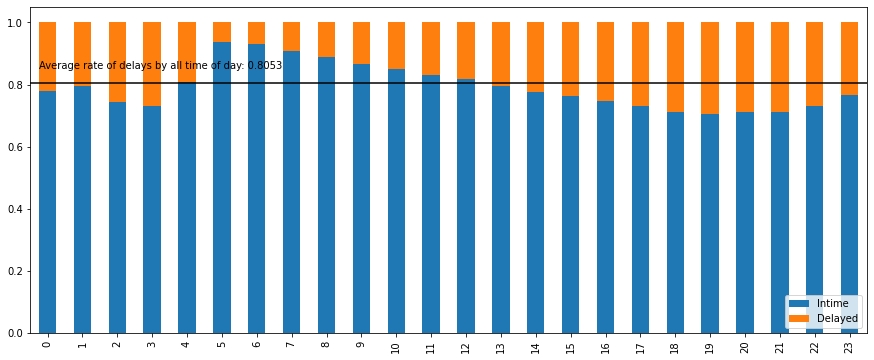

In [69]:
train_df['Dep_Hour'] = train_df['CRS_DEP_TIME'].apply(lambda x: x//100)
print(sorted(train_df['Dep_Hour'].unique()))
aggregateAndPlot('Dep_Hour', 'time of day')

Chart above indicates that more evening flights get delayed compared to morning flights. It is surprising for me as I would have expected that morning flights are delayed more.

And the last parameter I would like to check is the distance of flight. I believe that distance is related to `AIR_TIME` and `ELAPSED_TIMES` so they can be used interchangebly for the model.

In [70]:
train_df['Dist'] = train_df['DISTANCE'].apply(lambda x: x//100)
print(sorted(train_df['Dist'].unique()))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 32.0, 33.0, 34.0, 37.0, 38.0, 39.0, 41.0, 42.0, 44.0, 45.0, 48.0, 49.0, 50.0]


In [71]:
aggregateAndPlot('Dist', 'distances')

Flight distance affects the rate of delays, so it should be in the training data.

Next I build correlation heatmap. I should have done it first, however even now it can help to understand the data.

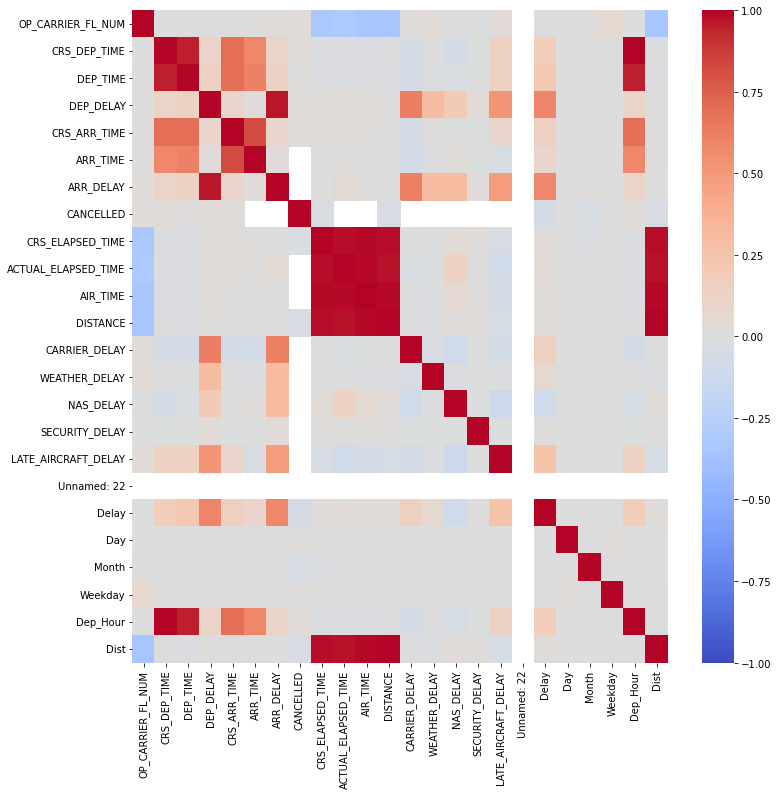

In [72]:
plt.figure(figsize = [12,12])
sns.heatmap(train_df.corr(), cmap='coolwarm', vmin = -1, vmax = 1)

There is a correlation between distance/airtime/elapsed_time group and airline. I think it might be due to the fact that different airlines target different types of flights. Large airlines fly long distances, while smaller airlines fly only short distance flights.  
Another group is departure times, which are correlated to arrival times group. It is normal that they are correlated as arrivel depends on departure.
Departure delay is correlated to types of delays, as ther is a delay the reason for it is given.
And the last group that is interrelated is a distance, airtime and elapsed time.


As a result of EDA and other observations, I decided that important information is contained in:
- airline
- flight number
- departure time
- arrival time
- flight date (day/ month/ weekday)
- distance

## Data cleaning and feature engineering
First of all I delete cancelled flights data, and other unnecessary flight information.




In [73]:
print(f'Shapes before dropping flights, train: {train_df.shape}; test: {test_df.shape};')
train_df.drop(train_df[train_df['CANCELLED']==1].index, inplace = True)
test_df.drop(test_df[test_df['CANCELLED']==1].index, inplace = True)
print(f'Shapes after dropping flights, train: {train_df.shape}; test: {test_df.shape};')

Shapes before dropping flights, train: (3738772, 29); test: (1317490, 27);
Shapes after dropping flights, train: (3666410, 29); test: (1269523, 27);


In [74]:
# Create departure hour and disnance columns in test set as in training set
test_df['Dep_Hour'] = test_df['CRS_DEP_TIME'].apply(lambda x: x//100)
test_df['Dist'] = test_df['DISTANCE'].apply(lambda x: x//100)

In [75]:
# Before feeding model feature engineered data, I want to try give it raw data.
# So, I will have two sets
raw_train_df = train_df.copy()
raw_test_df = test_df.copy()

In [76]:
# Drop currently unnecessary columns
raw_train_df.drop(['FL_DATE', 'DEP_TIME', 'DEP_DELAY','ARR_TIME','ARR_DELAY', 'CANCELLED', 
              'CANCELLATION_CODE','ACTUAL_ELAPSED_TIME', 'AIR_TIME','CARRIER_DELAY',
              'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
              'Unnamed: 22', 'Weekday', 'Dep_Hour', 'Dist'], axis = 1, inplace = True)

raw_test_df.drop(['FL_DATE', 'DEP_TIME', 'DEP_DELAY','ARR_TIME','ARR_DELAY', 'CANCELLED', 
              'CANCELLATION_CODE','ACTUAL_ELAPSED_TIME', 'AIR_TIME','CARRIER_DELAY',
              'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
              'Unnamed: 22', 'Weekday', 'Dep_Hour', 'Dist'], axis = 1, inplace = True)

# Use one hot method to replace Airline, origin and destination
raw_train_df = pd.get_dummies(raw_train_df, columns = ['OP_UNIQUE_CARRIER'])
raw_test_df = pd.get_dummies(raw_test_df, columns = ['OP_UNIQUE_CARRIER'])

# Will use label encoder for destination and origin, as dataset gets too big otherwise
from sklearn.preprocessing import LabelEncoder

for col in ['ORIGIN', 'DEST']:
  le = LabelEncoder()
  le.fit(raw_train_df[col])
  raw_train_df[col] = le.transform(raw_train_df[col])
  raw_test_df[col] = le.transform(raw_test_df[col])

In [77]:
# First I create flight numbers for each airline and will make it categorical (there is no use of integer flight number)

train_df['FlightNumber'] = train_df['OP_UNIQUE_CARRIER'] + '-' + train_df['OP_CARRIER_FL_NUM'].astype('str')
test_df['FlightNumber'] = test_df['OP_UNIQUE_CARRIER'] + '-' + test_df['OP_CARRIER_FL_NUM'].astype('str')

In [92]:
# when I tried to label encode flight numbers, I found out that there are new flights in test set that were not in training set
# I will try to find out how many records belong to these new flights
s1 = set(train_df['FlightNumber'].unique())
s2 = set(test_df['FlightNumber'].unique())
s3=s2-s1
print(len(s3))

410


There are 410 new flights in test set that are not in training set.


In [94]:
test_df[test_df['FlightNumber'].isin(s3)].shape

(4527, 30)

4527 entries in test dataframe belong to these new flights. It is not that much so I think it's OK to drop them.

In [110]:
test_df.loc[test_df['FlightNumber'].isin(s3),'FlightNumber']=np.nan
test_df.dropna(subset=['FlightNumber'], inplace = True)

In [111]:
# Next I drop columns that I think unnecessary

train_df.drop(['FL_DATE', 'OP_CARRIER_FL_NUM','DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME','ARR_TIME',
               'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE','ACTUAL_ELAPSED_TIME', 'AIR_TIME', 
               'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
               'LATE_AIRCRAFT_DELAY', 'Unnamed: 22',], axis = 1, inplace = True)

test_df.drop(['FL_DATE', 'OP_CARRIER_FL_NUM','DEP_TIME', 'DEP_DELAY', 'CRS_ARR_TIME','ARR_TIME',
              'ARR_DELAY', 'CANCELLED', 'CANCELLATION_CODE','ACTUAL_ELAPSED_TIME', 'AIR_TIME', 
              'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY',
              'LATE_AIRCRAFT_DELAY', 'Unnamed: 22',], axis = 1, inplace = True)

In [112]:
# To convert object typed data will use label encoder 
for col in train_df.columns:
  if train_df[col].dtypes == 'object':
    le = LabelEncoder()
    le.fit(train_df[col])
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# train_df = pd.get_dummies(train_df, columns = ['OP_UNIQUE_CARRIER'])
# test_df = pd.get_dummies(test_df, columns = ['OP_UNIQUE_CARRIER'])

## Model
I think for this data tree models will perform the best. As I am not planning to do hyperparameter tuning, I will only use test set and training set (no CV set).

In [114]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = [KNeighborsClassifier, LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, 
          ExtraTreeClassifier, BaggingClassifier, XGBClassifier, LGBMClassifier]

def run_classifier(X_train, X_test, y_train, y_test):
    acc = []
    bal_acc = []
    f1_list = []
    roc_auc = []
    precision_yes = []
    precision_no = []
    recall_yes = []
    recall_no = []
    
    # Loop to go through models
    for model in models:
        # Create classifier and fit to dataset
        clf = model()
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc.append(accuracy_score(y_test, y_pred))
        bal_acc.append(balanced_accuracy_score(y_test, y_pred))
        f1_list.append(f1_score(y_test, y_pred))
        precision_yes.append(precision_score(y_test,y_pred, pos_label = 1))
        precision_no.append(precision_score(y_test,y_pred, pos_label = 0))
        recall_yes.append(recall_score(y_test,y_pred, pos_label = 1))
        recall_no.append(recall_score(y_test,y_pred, pos_label = 0))

        y_pred_prob = clf.predict_proba(X_test)[:,1]
        roc_auc.append(roc_auc_score(y_test, y_pred_prob))

    d = {'accuracy':XGBClassifier, 'balanced_accuracy':bal_acc, 'f1_score':f1_list, 'precision_yes':precision_yes, 'precision_no':precision_no, 'recall_yes':recall_yes, 'recall_no':recall_no, 'roc_auc':roc_auc}
    df_mods = pd.DataFrame(d, index = map(str, models)).round(3)
    return(df_mods)

In [119]:
X_train = raw_train_df.drop(['Delay'], axis = 1)
y_train = raw_train_df['Delay']

X_test = raw_test_df.drop(['Delay'], axis = 1)
y_test = raw_test_df['Delay']

In [121]:
models = [LGBMClassifier, XGBClassifier]

result_df_raw = run_classifier(X_train, X_test, y_train, y_test)
result_df_raw.head(15)

,accuracy,balanced_accuracy,f1_score,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'xgboost.sklearn.XGBClassifier'>,0.518,0.091,0.482,0.800,0.051,0.986,0.685
<class 'xgboost.sklearn.XGBClassifier'>,<class 'xgboost.sklearn.XGBClassifier'>,0.500,0.000,0.789,0.794,0.000,1.000,0.680


In [115]:
X_train = train_df.drop(['Delay'], axis = 1)
y_train = train_df['Delay']

X_test = test_df.drop(['Delay'], axis = 1)
y_test = test_df['Delay']

In [118]:
models = [LGBMClassifier, XGBClassifier]

result_df_raw = run_classifier(X_train, X_test, y_train, y_test)
result_df_raw.head(15)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,balanced_accuracy,f1_score,precision_yes,precision_no,recall_yes,recall_no,roc_auc
<class 'lightgbm.sklearn.LGBMClassifier'>,<class 'xgboost.sklearn.XGBClassifier'>,0.519,0.095,0.481,0.800,0.053,0.985,0.683
<class 'xgboost.sklearn.XGBClassifier'>,<class 'xgboost.sklearn.XGBClassifier'>,0.500,0.000,0.000,0.794,0.000,1.000,0.677


Unfortunately modeling part was not successful. It could have been beneficial if I could use one-hot labeling, however colab couldn't handle that big dataset.


As per initial plan different models could be built to predict each type of delay.

In [124]:
sum(y_test)/y_test.shape[0]

0.20598208933591594